In [17]:
import sys, yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.paychex_ml.external_data import get_bls_data
from src.paychex_ml.external_data import get_census_data
from src.paychex_ml.external_data import get_fred_data

In [6]:
## Change the project path
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [8]:
sys.path.append(proyect_path)

# Data

## FRED

In [3]:
series_dict = {
    'Nation Income & Expenditures': ['GDPC1', 'GDPPOT', 'W875RX1', 'PCEC96', 'PSAVERT', 'FYFR', 'FYONET', 'FYFSD','GFDEBTN'],
    'Pop Employment Labor': ['PAYEMS', 'UNRATE', 'ICSA', 'UEMPMEAN', 'JTSJOL', 'AWHMAN', 'AHETPI', 'OPHNFB', 'POP', 'CLF16OV',
                             'CIVPART'],
    'Prod & Bus Act': ['INDPRO', 'TCU', 'BUSINV', 'RRSFS', 'ALTSALES', 'DGORDER', 'BUSLOANS', 'TOTALSL', 'CP', 'HOUST', 'PERMIT',
                       'UNDCONTSA'],
    'Prices': ['CPIAUCSL', 'PCEPI', 'PCEPILFE', 'GDPDEF', 'PPIFIS', 'WPSFD49207', 'WPSFD4131', 'WPSID62', 'USSTHPI', 'SPCS20RSA',
               'DCOILWTICO', 'GASREGW', 'MHHNGSP'],
    'Money Bank Finance': ['BOGMBASE', 'M1SL', 'M2SL', 'SP500', 'DJIA', 'WILL5000IND', 'VIXCLS', 'STLFSI2', 'BAMLCC0A2AATRIV', 'FF', 'WGS3MO', 'WGS1YR', 'WGS5YR', 'WFII5', 'WGS10YR', 'WFII10', 'WAAA', 'WBAA', 'MORTGAGE15US', 'MORTGAGE30US', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS']

}

In [73]:
# Get external data with function
df_ext = get_fred_data(series_dict, write_excel=True)
df_ext = df_ext.droplevel(0, axis=1)

Loading category:  Nation Income & Expenditures
Loading series:  GDPC1
Loading series:  GDPPOT
Loading series:  W875RX1
Loading series:  PCEC96
Loading series:  PSAVERT
Loading series:  FYFR
Loading series:  FYONET
Loading series:  FYFSD
Loading series:  GFDEBTN
Category Nation Income & Expenditures save in external_data.xlsx.
Loading category:  Pop Employment Labor
Loading series:  PAYEMS
Loading series:  UNRATE
Loading series:  ICSA
Loading series:  UEMPMEAN
Loading series:  JTSJOL
Loading series:  AWHMAN
Loading series:  AHETPI
Loading series:  OPHNFB
Loading series:  POP
Loading series:  CLF16OV
Loading series:  CIVPART
Category Pop Employment Labor save in external_data.xlsx.
Loading category:  Prod & Bus Act
Loading series:  INDPRO
Loading series:  TCU
Loading series:  BUSINV
Loading series:  RRSFS
Loading series:  ALTSALES
Loading series:  DGORDER
Loading series:  BUSLOANS
Loading series:  TOTALSL
Loading series:  CP
Loading series:  HOUST
Loading series:  PERMIT
Loading series:

In [76]:
# Read external data from saved with the funcion
df_ext = pd.read_csv(proyect_path+"/data/external/external_data_fred.csv")
df_ext = df_ext.set_index('date')
df_ext.index = df_ext.index.astype(str)

<AxesSubplot:xlabel='date'>

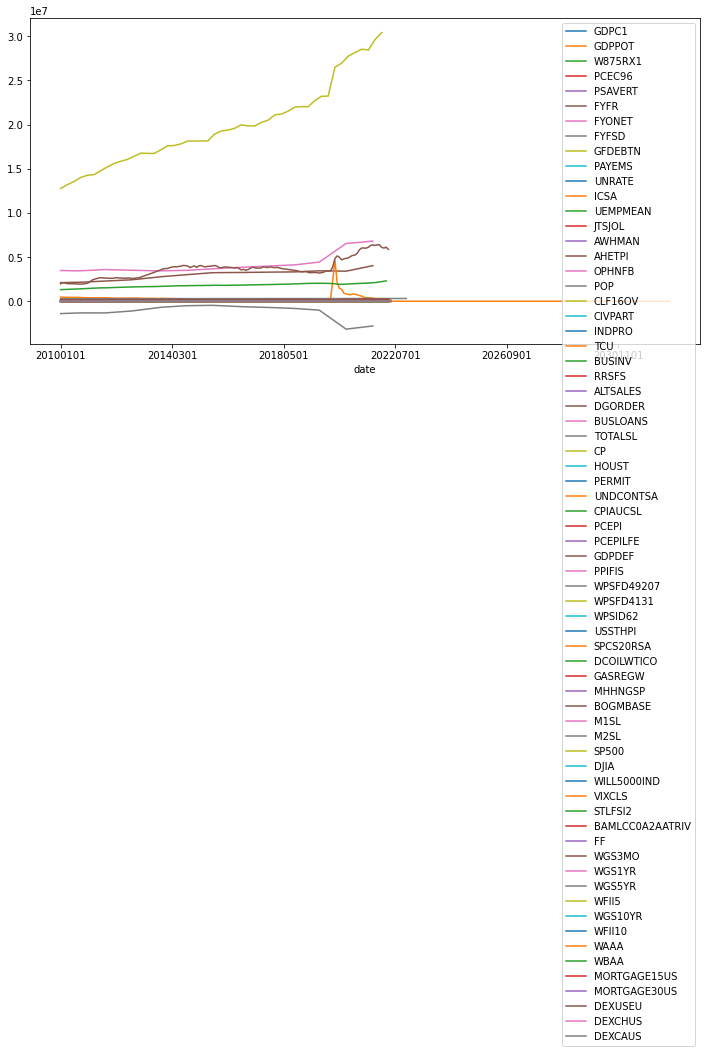

In [78]:
df_ext.plot(figsize=(12,6))

In [16]:
# Download file
file = 'table_predictable.csv'
df = pd.read_csv(proyect_path+"/data/clean/" +file, dtype={'Period':str, 'Calendar Date': str})

In [18]:
with open(proyect_path + "/src/line_items.yml", "r") as stream:
    items_dicctionary = yaml.safe_load(stream)

In [29]:
items = [ i[0] for i in items_dicctionary.values() if i[2]==0]

In [22]:
df_items = df[(df['Scenario']=='Actual')&(df['Item'].isin(items))]\
    .groupby(['Calendar Date', 'Item']).sum()\
    .unstack(level=1)['Value']

In [25]:
def correlation_analysis(item, df_items, df_ext, lag=0, plot=True, figsize=(16,18)):

    # Join tables
    df_join = df_items[item].to_frame().join(df_ext.shift(lag))
    df_join.index = pd.to_datetime(df_join.index)

    # Calculate corelations
    cor = df_join.corr()[item][1:]

    if plot:
        # Fist plot: time series item vs external data
        m = 4
        n = np.ceil((df_join.shape[1]-1)/m).astype(int)
        fig, axs = plt.subplots(n, m, sharex=True, sharey=True, figsize=figsize)
        axsf = axs.flat
        i=0
        for c in df_join.columns[1:]:
            ax1 = axsf[i]
            ax1.plot(df_join.iloc[:,0], color='darkblue', lw=1)
            ax2 = ax1.twinx()
            ax2.plot(df_join[c], color = 'red', ls="--", label=c, lw=1)
            ax2.legend(fontsize='x-small', frameon=False)
            i+=1
        plt.suptitle("{} vs external data timelines".format(item), fontsize=14)
        plt.tight_layout()
        plt.show()

        # Second plot: correlations
        fig, ax = plt.subplots(figsize=(16,4))
        cor.plot.bar(ax=ax, title="Correlations {} vs external data".format(item))
        plt.show()

    return cor

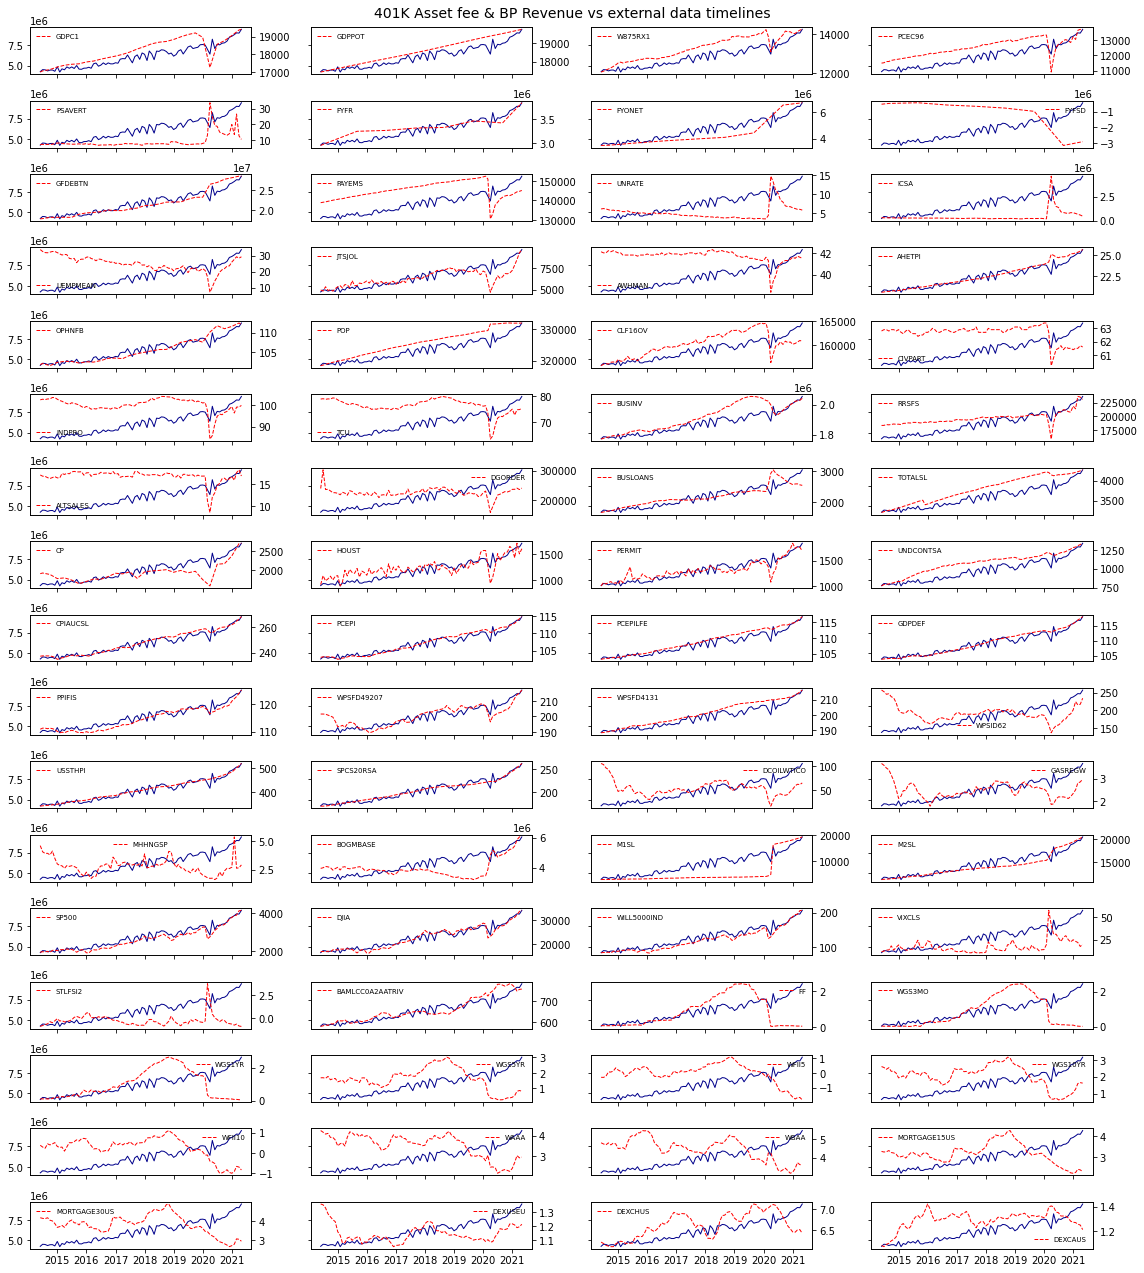

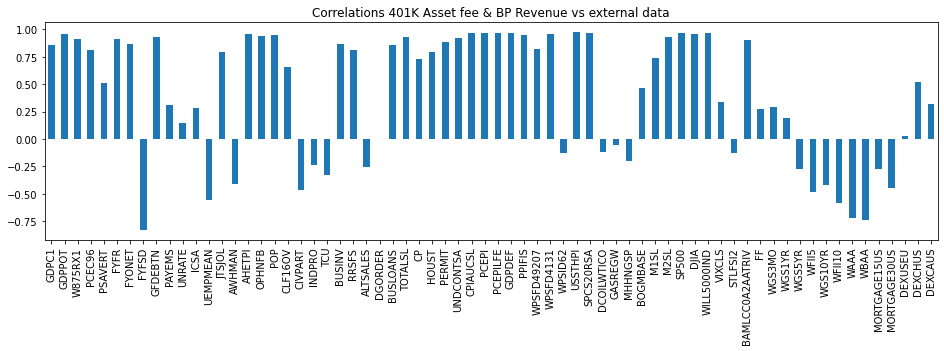

In [79]:
item = '401K Asset fee & BP Revenue'
c0 = correlation_analysis(item, df_items, df_ext)

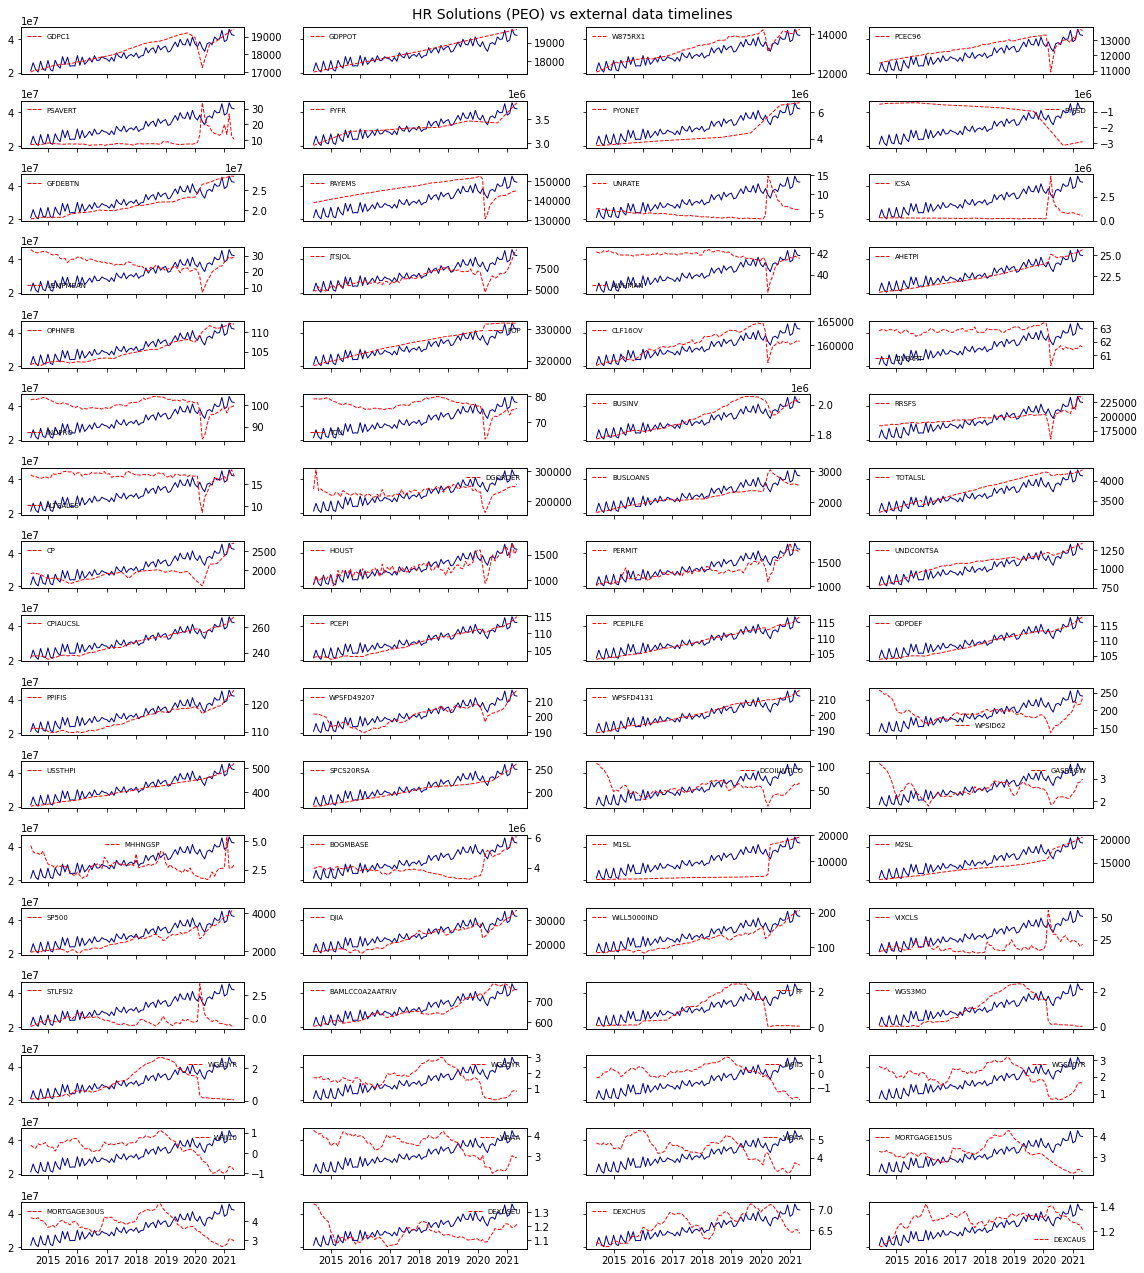

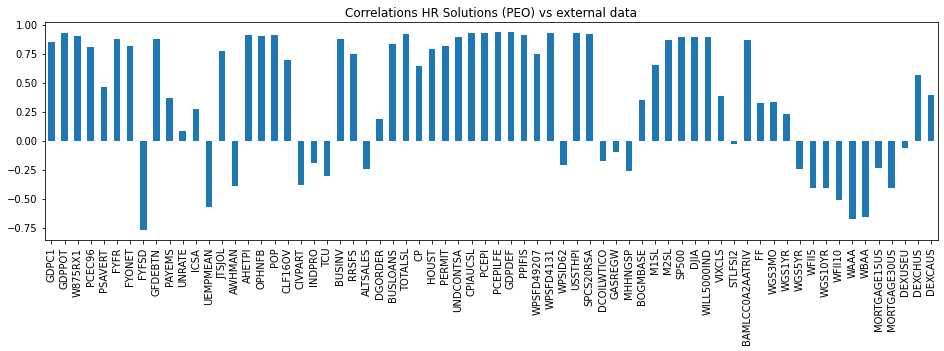

In [124]:
item = 'HR Solutions (PEO)'
c0 = correlation_analysis(item, df_items, df_ext, lag=0)

In [31]:
list_correlations = []
for item in items:
    print('Analysis for item {}.'.format(item))
    c = correlation_analysis(item, df_items, df_ext, plot=False)
    list_correlations.append(c)

Analysis for item Payroll blended products.


C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_join = df_items[item].to_frame().join(df_ext.shift(lag))
C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_join = df_items[item].to_frame().join(df_ext.shift(lag))
C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_join = df_items[item].to_frame().join(df_ext.shift(lag))
C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in

Analysis for item W-2 Revenue.
Analysis for item Delivery Revenue.
Analysis for item ASO Allocation.
Analysis for item Other Processing Revenue.
Analysis for item SurePayroll..
Analysis for item Total international.
Analysis for item 401K Fee Revenue.
Analysis for item 401K Asset fee & BP Revenue.
Analysis for item HR Solutions (PEO).
Analysis for item ASO Revenue - Oasis.
Analysis for item HR Online.
Analysis for item Time & Attendance.
Analysis for item Total Paychex Advance.
Analysis for item Full Service Unemployment Revenue.
Analysis for item ESR Revenue.
Analysis for item Cafeteria Plans Revenue.
Analysis for item Benetrac.
Analysis for item Emerging Products.
Analysis for item Total PEO.
Analysis for item Workers Comp - Payment Services.
Analysis for item Health Benefits.
Analysis for item Interest on Funds Held for Clients.


C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_join = df_items[item].to_frame().join(df_ext.shift(lag))
C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_join = df_items[item].to_frame().join(df_ext.shift(lag))
C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_join = df_items[item].to_frame().join(df_ext.shift(lag))
C:\Users\bruno.gonzalez\AppData\Local\Temp\ipykernel_25568\2531444136.py:4: FutureWarning: merging between different levels is deprecated and will be removed in

In [32]:
df_cor = pd.concat(list_correlations, axis=1)

In [33]:
df_cor

,Payroll blended products,W-2 Revenue,Delivery Revenue,ASO Allocation,Other Processing Revenue,SurePayroll.,Total international,401K Fee Revenue,401K Asset fee & BP Revenue,HR Solutions (PEO),...,Total Paychex Advance,Full Service Unemployment Revenue,ESR Revenue,Cafeteria Plans Revenue,Benetrac,Emerging Products,Total PEO,Workers Comp - Payment Services,Health Benefits,Interest on Funds Held for Clients
"(Nation Income & Expenditures, GDPC1)",0.094331,0.040404,0.032207,0.834102,0.284501,0.706152,0.825640,0.683384,0.858023,0.850434,...,0.820859,0.775549,0.419447,0.017888,-0.632363,0.654585,0.813965,0.400945,0.813997,-0.202083
"(Nation Income & Expenditures, GDPPOT)",-0.070560,0.001919,-0.019801,0.917837,0.242185,0.785620,0.923999,0.774037,0.958027,0.929216,...,0.816256,0.807324,0.444067,-0.055226,-0.712639,0.836836,0.908748,0.295012,0.904706,-0.413171
"(Nation Income & Expenditures, W875RX1)",0.023757,0.035866,0.008592,0.888998,0.291050,0.772077,0.890271,0.755542,0.915801,0.904642,...,0.831243,0.812630,0.477294,0.054750,-0.662269,0.735678,0.889108,0.406474,0.880865,-0.277914
"(Nation Income & Expenditures, PCEC96)",0.115532,0.061453,0.034349,0.787332,0.285566,0.651160,0.754534,0.630741,0.815201,0.804022,...,0.803154,0.739747,0.438684,0.051916,-0.594515,0.642966,0.752128,0.434150,0.776117,-0.206180
"(Nation Income & Expenditures, PSAVERT)",-0.293157,-0.005448,-0.017977,0.473320,0.107876,0.385594,0.507809,0.426182,0.514989,0.465646,...,0.261694,0.328453,0.125870,-0.218407,-0.347021,0.612429,0.468765,-0.119644,0.472791,-0.429554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Money Bank Finance, MORTGAGE15US)",0.151469,-0.002164,0.037089,-0.253111,0.024009,-0.222777,-0.122560,-0.160146,-0.273563,-0.236405,...,-0.044544,-0.129929,0.001492,0.326716,0.198769,-0.556152,-0.191659,0.347487,-0.184801,0.755256
"(Money Bank Finance, MORTGAGE30US)",0.155735,-0.000742,0.032692,-0.420808,-0.021705,-0.375730,-0.312937,-0.331070,-0.444188,-0.407388,...,-0.198910,-0.289523,-0.084708,0.299012,0.345882,-0.670161,-0.372969,0.260246,-0.346871,0.780240
"(Money Bank Finance, DEXUSEU)",-0.076276,0.026995,-0.031073,-0.046892,-0.039132,-0.027249,0.041853,0.042393,0.026992,-0.060611,...,-0.175912,-0.173546,-0.202803,-0.005557,-0.018128,0.103261,-0.064898,-0.103129,-0.021092,-0.060161
"(Money Bank Finance, DEXCHUS)",0.060908,-0.066336,-0.016014,0.547955,0.090502,0.473956,0.506299,0.447997,0.517787,0.567444,...,0.678997,0.590097,0.346936,0.106951,-0.497208,0.302126,0.557930,0.311397,0.483390,-0.128523


<AxesSubplot:>

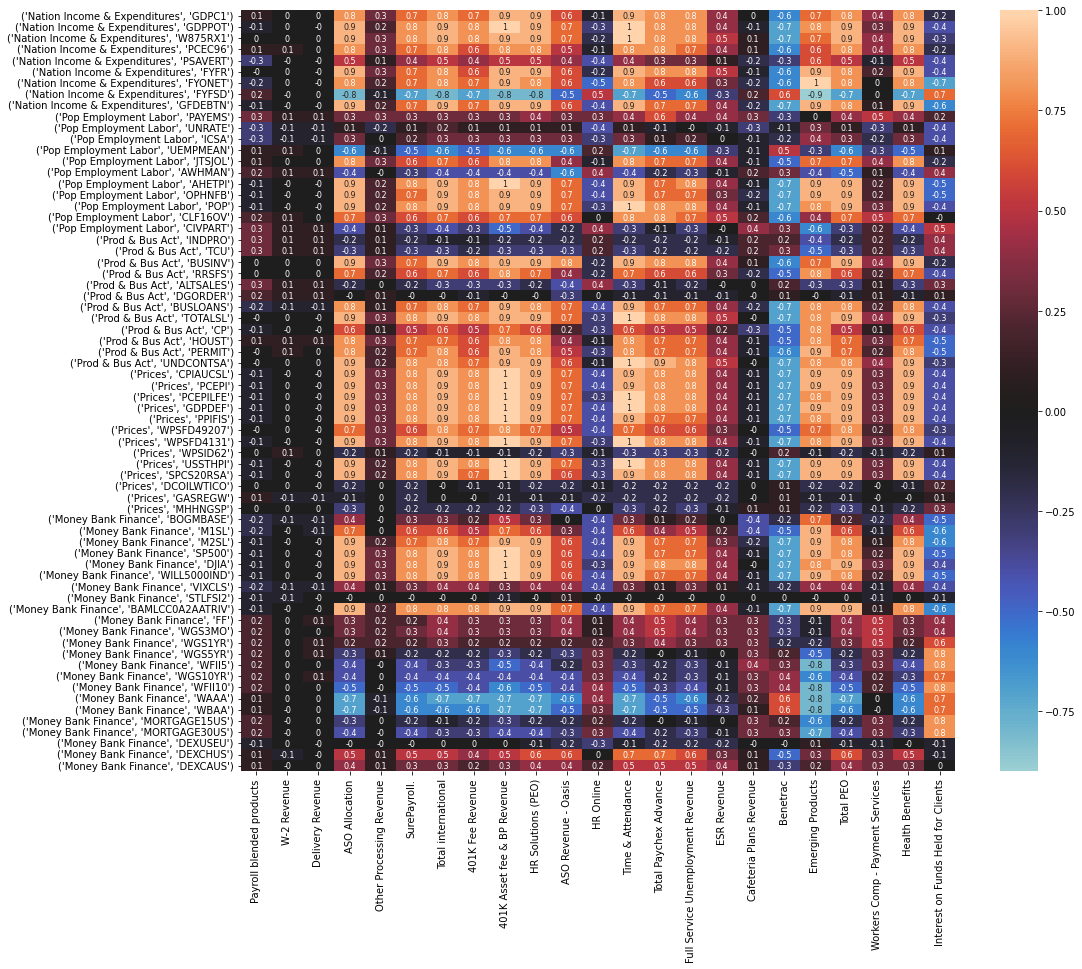

In [34]:
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(df_cor.round(1), annot=True, center=0, annot_kws={"size":8}, ax=ax)

## External data selecction

In [35]:
corr_ext = df_ext.droplevel(0, axis=1).corr()

<AxesSubplot:>

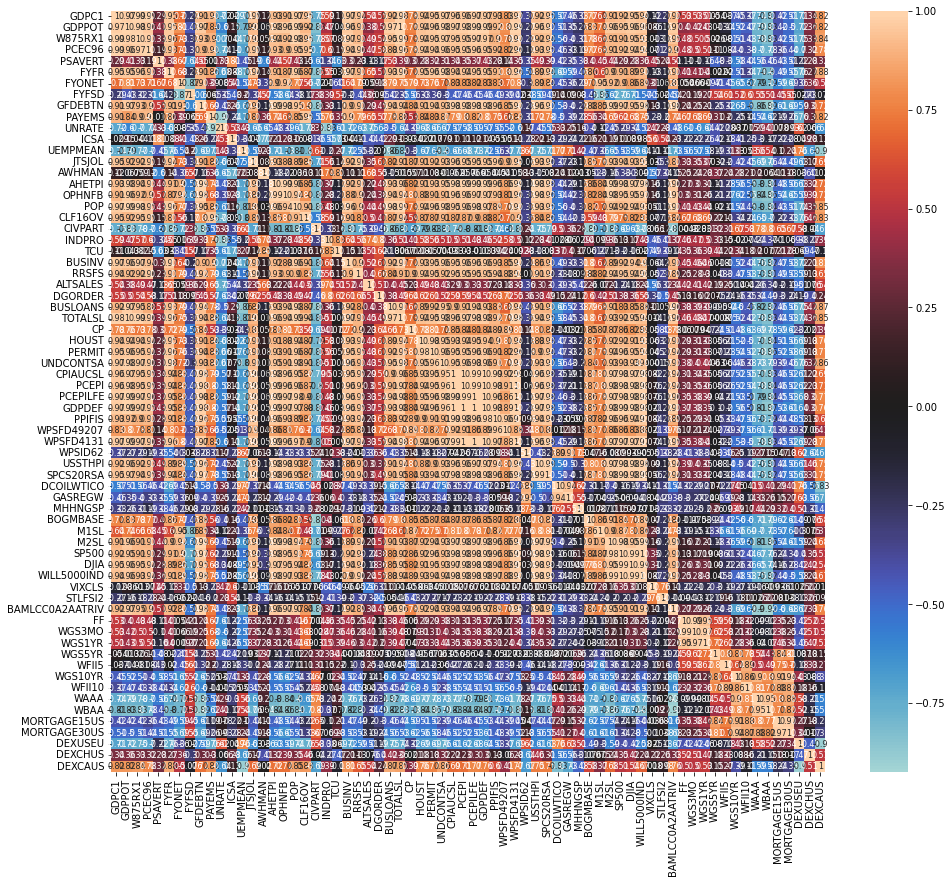

In [36]:
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(corr_ext, annot=True, center=0, annot_kws={"size":8}, ax=ax)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [38]:
X = df_ext[(df_ext.index>='20140601')&(df_ext.index<='20210501')].droplevel(0, axis=1)

In [40]:
def multi_selection(X, n_drop = 3):

    X_sel=X.copy()
    X_sel['intercept'] = 1

    if n_drop == 'all':
        x_vif=100
        while x_vif >10:

            vif = pd.DataFrame()
            vif["Variable"] = X_sel.columns
            vif["VIF"] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]
            vif = vif[(vif['Variable']!='intercept')&(~np.isinf(vif['VIF']))].sort_values('VIF', ascending=False)
            x_del = vif.iloc[0,0]
            x_vif = vif.iloc[0,1]
            X_sel = X_sel.drop(x_del, axis=1)
            print("Droped column: {} \t vif: {}".format(x_del, x_vif))

    else:
        for n in range(n_drop):
            vif = pd.DataFrame()
            vif["Variable"] = X_sel.columns
            vif["VIF"] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]
            vif = vif[(vif['Variable']!='intercept')&(~np.isinf(vif['VIF']))].sort_values('VIF', ascending=False)
            x_del = vif.iloc[0,0]
            X_sel = X_sel.drop(x_del, axis=1)
            print("Droped column: {} \t vif: {}".format(x_del, vif.iloc[0,1]))

    X_sel = X_sel.drop('intercept', axis=1)
    return X_sel

In [41]:
X_sel = multi_selection(X, n_drop=48)

C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: GDPPOT 	 vif: 237749.798216025
Droped column: SP500 	 vif: 81587.24509486143


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: M2SL 	 vif: 70104.38745592366
Droped column: PCEPI 	 vif: 63715.58271607737


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: SPCS20RSA 	 vif: 48351.84215508498
Droped column: TCU 	 vif: 24188.22669123809


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: POP 	 vif: 19547.653951177188
Droped column: AHETPI 	 vif: 16134.474948702373


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEPILFE 	 vif: 13811.980473450098
Droped column: GDPDEF 	 vif: 12502.988534020076


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: CPIAUCSL 	 vif: 10032.165919584128
Droped column: USSTHPI 	 vif: 7959.717339780164


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WPSFD4131 	 vif: 5642.823660970836
Droped column: BAMLCC0A2AATRIV 	 vif: 5112.153909488713


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: GFDEBTN 	 vif: 3830.5833007310516
Droped column: WGS5YR 	 vif: 3482.124870321483
Droped column: MORTGAGE30US 	 vif: 2444.8209128887283


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEC96 	 vif: 2257.090389426869
Droped column: WILL5000IND 	 vif: 2179.81525264212
Droped column: WGS3MO 	 vif: 2156.176045851594


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PAYEMS 	 vif: 1712.7553894104724
Droped column: PPIFIS 	 vif: 1215.748662601147
Droped column: BUSLOANS 	 vif: 1127.9577492796016


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: BUSINV 	 vif: 1008.7056956427325
Droped column: UNDCONTSA 	 vif: 732.8249168660922
Droped column: TOTALSL 	 vif: 651.429637676679
Droped column: CLF16OV 	 vif: 613.4440483317171


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WFII10 	 vif: 534.9025068321215
Droped column: W875RX1 	 vif: 473.3433265540584
Droped column: DJIA 	 vif: 423.6818018745192
Droped column: OPHNFB 	 vif: 399.142415887626
Droped column: WGS10YR 	 vif: 391.39757619045724
Droped column: M1SL 	 vif: 274.1139943977867
Droped column: WGS1YR 	 vif: 230.45329634832757


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif =

Droped column: WAAA 	 vif: 229.09587945059477
Droped column: WPSFD49207 	 vif: 142.6842969360111
Droped column: GDPC1 	 vif: 126.42532390454409
Droped column: WFII5 	 vif: 107.62778691397104
Droped column: BOGMBASE 	 vif: 76.81527786264087
Droped column: ICSA 	 vif: 66.53264025926393
Droped column: UNRATE 	 vif: 60.96127513985998
Droped column: WPSID62 	 vif: 43.4413854844947
Droped column: RRSFS 	 vif: 31.374265508140724


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif =

Droped column: JTSJOL 	 vif: 27.633057809130154
Droped column: DCOILWTICO 	 vif: 24.35355780261543
Droped column: UEMPMEAN 	 vif: 22.601068470652837
Droped column: FF 	 vif: 18.654134154512498
Droped column: VIXCLS 	 vif: 15.930107327661919


C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\bruno.gonzalez\Miniconda3\envs\paychenv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<AxesSubplot:>

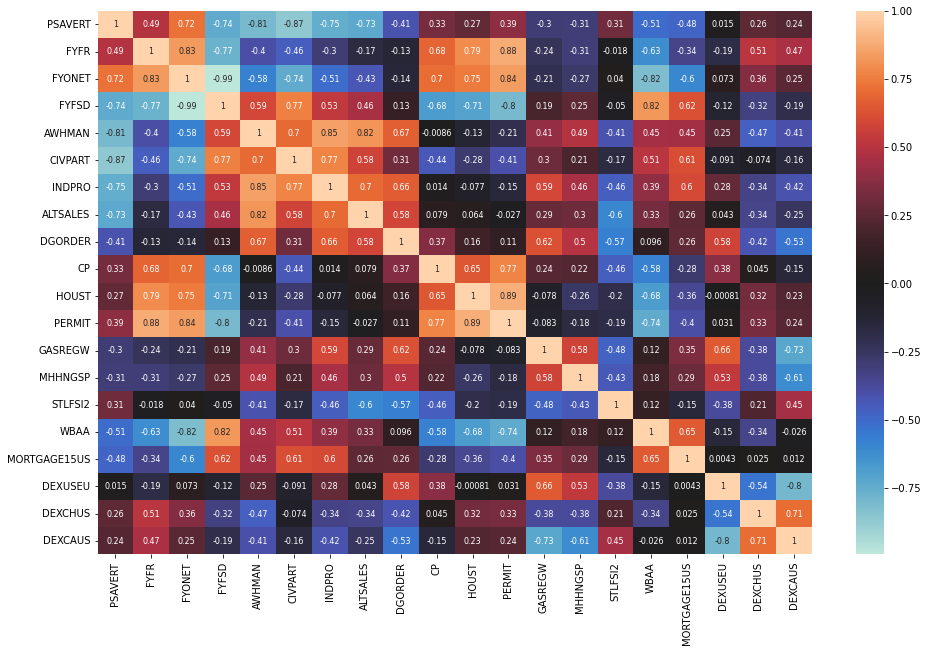

In [42]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(X_sel.corr(), annot=True, center=0, annot_kws={"size":8}, ax=ax)

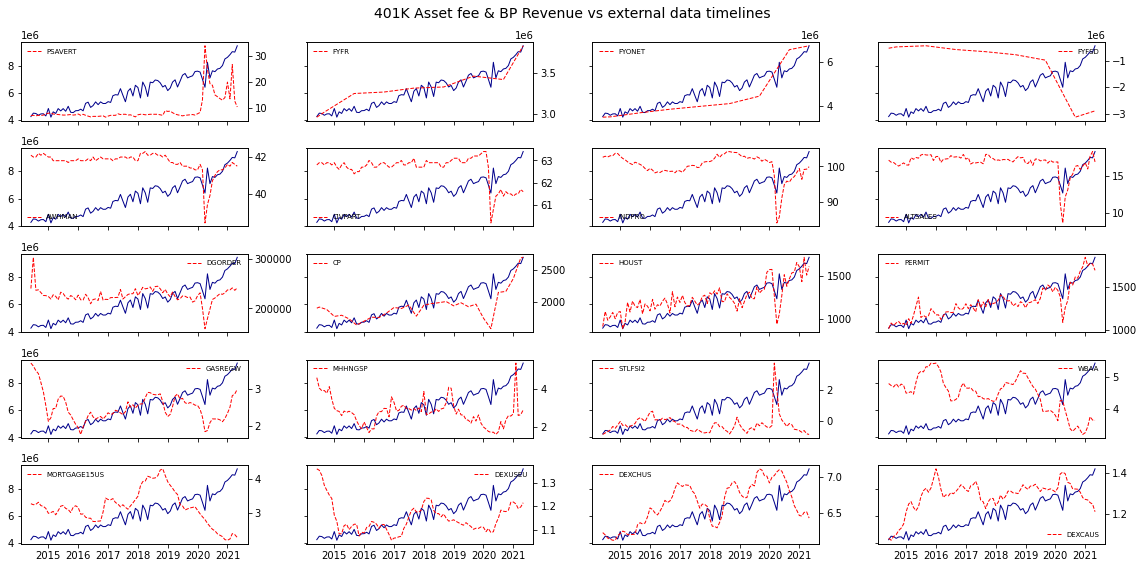

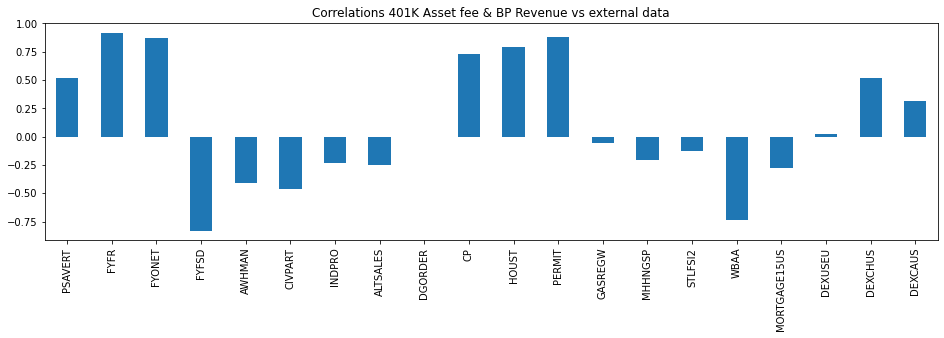

In [43]:
item = '401K Asset fee & BP Revenue'
c0 = correlation_analysis(item, df_items, X_sel, figsize=(16,8))

In [44]:
list_correlations2 = []
for item in items:
    print('Analysis for item {}.'.format(item))
    c = correlation_analysis(item, df_items, X_sel, plot=False)
    list_correlations2.append(c)

Analysis for item Payroll blended products.
Analysis for item W-2 Revenue.
Analysis for item Delivery Revenue.
Analysis for item ASO Allocation.
Analysis for item Other Processing Revenue.
Analysis for item SurePayroll..
Analysis for item Total international.
Analysis for item 401K Fee Revenue.
Analysis for item 401K Asset fee & BP Revenue.
Analysis for item HR Solutions (PEO).
Analysis for item ASO Revenue - Oasis.
Analysis for item HR Online.
Analysis for item Time & Attendance.
Analysis for item Total Paychex Advance.
Analysis for item Full Service Unemployment Revenue.
Analysis for item ESR Revenue.
Analysis for item Cafeteria Plans Revenue.
Analysis for item Benetrac.
Analysis for item Emerging Products.
Analysis for item Total PEO.
Analysis for item Workers Comp - Payment Services.
Analysis for item Health Benefits.
Analysis for item Interest on Funds Held for Clients.


In [45]:
df_cor2 = pd.concat(list_correlations2, axis=1)

<AxesSubplot:>

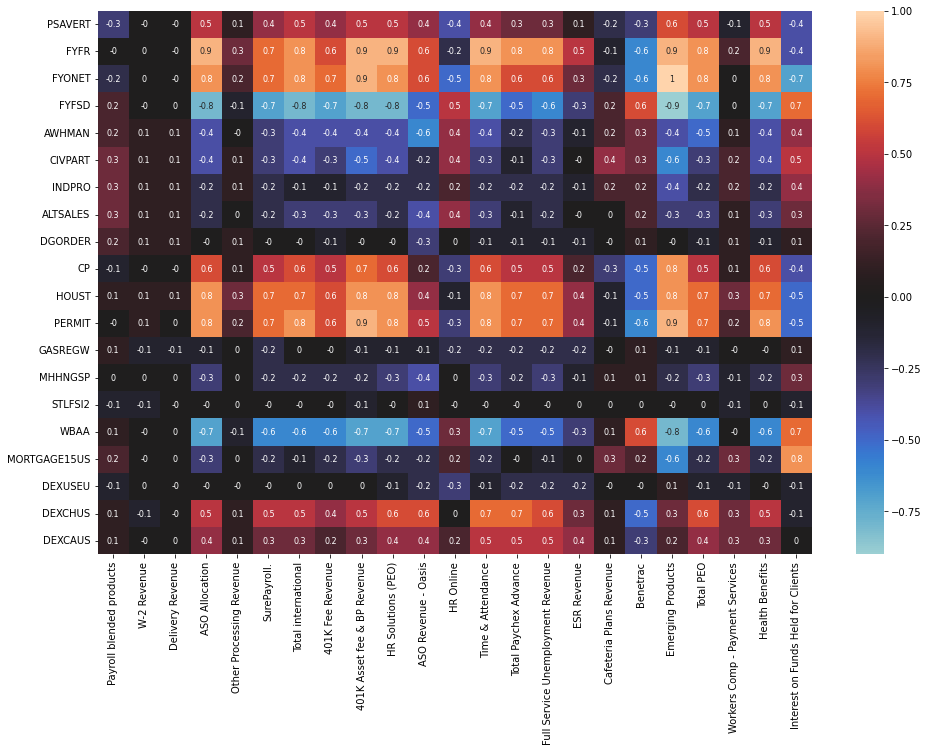

In [46]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df_cor2.round(1), annot=True, center=0, annot_kws={"size":8}, ax=ax)

In [266]:
X_sel.reset_index().to_feather("ext_var_sel.feather")

### Selectin with threshold

In [261]:
X_sel2 = multi_selection(X, n_drop='all')

c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: GDPPOT 	 vif: 205890.68967051964
Droped column: PCEPI 	 vif: 86019.07234142236


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: M2SL 	 vif: 79944.71769646679
Droped column: SP500 	 vif: 67525.00626940589


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: SPCS20RSA 	 vif: 59226.6497566616
Droped column: TCU 	 vif: 27945.647813481406


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: POP 	 vif: 18765.95833310485
Droped column: AHETPI 	 vif: 17283.401694753164


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEPILFE 	 vif: 15353.072363851456
Droped column: GDPDEF 	 vif: 11069.081345232471


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: USSTHPI 	 vif: 10323.199624485987
Droped column: CPIAUCSL 	 vif: 8068.331057576667


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WPSFD4131 	 vif: 5448.739418238942
Droped column: BAMLCC0A2AATRIV 	 vif: 5138.449160420611


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WGS5YR 	 vif: 3657.8676974940277
Droped column: GFDEBTN 	 vif: 3355.1395644073605


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: PCEC96 	 vif: 3285.727511064036
Droped column: MORTGAGE30US 	 vif: 2450.3171478407803
Droped column: WGS3MO 	 vif: 2233.587605746125


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: WILL5000IND 	 vif: 2093.052383227851
Droped column: PAYEMS 	 vif: 1744.4510112298221
Droped column: PPIFIS 	 vif: 1300.928337761373


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: BUSLOANS 	 vif: 1105.7052330836596
Droped column: UNDCONTSA 	 vif: 936.794911364836
Droped column: BUSINV 	 vif: 746.4901552643834
Droped column: TOTALSL 	 vif: 682.3678774432451


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Droped column: CLF16OV 	 vif: 608.6304393985179
Droped column: WFII10 	 vif: 528.3616409266547
Droped column: OPHNFB 	 vif: 497.68835491600447
Droped column: W875RX1 	 vif: 411.0017279996988
Droped column: DJIA 	 vif: 399.0734157989279
Droped column: WGS10YR 	 vif: 383.1343994745231


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

Droped column: M1SL 	 vif: 273.2252830237664
Droped column: WAAA 	 vif: 234.3983417938069
Droped column: WGS1YR 	 vif: 225.75353973307963
Droped column: WPSFD49207 	 vif: 143.26877303466281
Droped column: GDPC1 	 vif: 123.52004717112382
Droped column: WFII5 	 vif: 103.29484743748863
Droped column: BOGMBASE 	 vif: 69.92728217845952
Droped column: ICSA 	 vif: 61.95647198488413
Droped column: UNRATE 	 vif: 61.47582535969381
Droped column: WPSID62 	 vif: 42.760034156838046


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

Droped column: RRSFS 	 vif: 29.025329312384407
Droped column: JTSJOL 	 vif: 27.752579386129437
Droped column: DCOILWTICO 	 vif: 25.087701773715782
Droped column: FF 	 vif: 23.220954666459388
Droped column: UEMPMEAN 	 vif: 19.949045674239496
Droped column: AWHMAN 	 vif: 16.562241426294687
Droped column: VIXCLS 	 vif: 15.855031968443674
Droped column: DEXCAUS 	 vif: 14.594650970512745
Droped column: PERMIT 	 vif: 14.055028980330494
Droped column: CIVPART 	 vif: 12.410569500435251
Droped column: WBAA 	 vif: 8.163164747575282


c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_square

In [262]:
X_sel2

,PSAVERT,FYFR,FYONET,FYFSD,INDPRO,ALTSALES,DGORDER,CP,HOUST,GASREGW,MHHNGSP,STLFSI2,MORTGAGE15US,DEXUSEU,DEXCHUS
date,,,,,,,,,,,,,,,
20140601,7.1,2.959388e+06,3.493328e+06,-5.339391e+05,102.5722,17.125,239998.0,1900.418780,911.0,3.69160,4.59,-0.884450,3.2650,1.359486,6.230605
20140701,7.2,2.979639e+06,3.497553e+06,-5.179132e+05,102.8479,16.851,304221.0,1917.769000,1085.0,3.61125,4.05,-0.789300,3.2360,1.353336,6.198436
20140801,7.0,3.000565e+06,3.501918e+06,-5.013531e+05,102.6491,16.808,235113.0,1904.742261,984.0,3.48650,3.91,-0.699140,3.2475,1.331524,6.154129
20140901,7.2,3.021491e+06,3.506284e+06,-4.847930e+05,102.9858,16.527,240539.0,1891.715522,1023.0,3.40620,3.92,-0.599750,3.3075,1.288910,6.138229
20141001,7.1,3.040264e+06,3.521536e+06,-4.812725e+05,102.9911,16.326,231947.0,1879.109000,1074.0,3.17050,3.78,-0.365240,3.2100,1.267732,6.125050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,99.4076,16.779,243160.0,2367.593000,1625.0,2.33425,2.71,-0.634300,2.2000,1.217767,6.467178
20210201,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,96.3966,15.932,246261.0,2478.777944,1447.0,2.50100,5.35,-0.744350,2.2375,1.209395,6.460058
20210301,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,99.1618,17.641,249467.0,2579.203056,1725.0,2.81040,2.62,-0.631475,2.3925,1.190161,6.510861


## Correlations over time

In [251]:
def correlation_lag(df_item, df_ext, item, ext, lag=12, plot=True):

    s_item = df_item[item]
    s_ext = df_ext[ext]

    list_series = [s_item]
    for l in range(lag+1):
        list_series.append(s_ext.shift(l).rename(ext+'_lag{}'.format(l)))

    df_cor = pd.concat(list_series, axis=1, join='inner').corr()[item][1:]

    if plot:
        fig, ax = plt.subplots(figsize=(10,3))
        df_cor.plot\
            .bar(title="Correlation over time {} vs {} (obs. {})".format(item, ext, list_series[1].shape[0]),
                 rot=90,
                 ax=ax)
    return df_cor

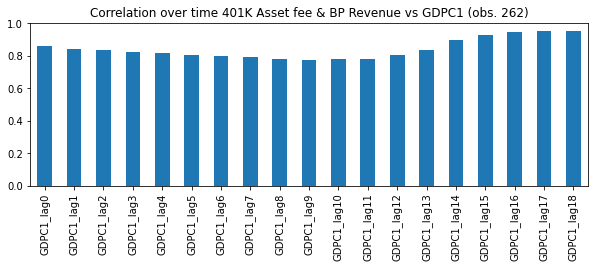

In [252]:
df_cor_lag = correlation_lag(df_items, df_ext.droplevel(0, axis=1), item, 'GDPC1', lag=18)